---
### Coupling two probability distributions with high probability of equality  
---

**Course:** *Simulation and Monte Carlo Methods* (2nd Semester, ENSAE Paris)  
**Authors:** Piero PELOSI, Omar EL MAMOUNE, Sarakpy NY  
**Supervisor:** Yvann LE FAY

Given two probability distributions $p$ and $q$, we are interested in constructing a joint distribution (coupling) for $(X,Y)$ such that $X \sim p$, $Y \sim q$, and $P(X=Y)$ is as large as possible. The paper [*The Coupled Rejection Sampler*](https://arxiv.org/abs/2201.09585) proposes a method to achieve this goal and shows how it can be applied to the case of two multivariate Gaussian distributions with different covariance matrices.

This project consists in implementing the proposed approach and comparing it with a simpler, classical algorithm known as Thorisson’s algorithm (Appendix 1 in the paper). We will explain why Thorisson’s algorithm is valid, how it relates to rejection sampling, and then examine several scenarios of increasing dimension. Since the running time of these algorithms is itself a random variable, we will also comment on its distribution and practical implications.

If time permits, we may additionally explore how such a coupling can be embedded in a random-walk Metropolis setting (as in Section 5.3 of the reference paper), and attempt to replicate some of those experiments. 

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
#### Modified Thorisson algorithm

<div align="center">
    <img src="https://raw.githubusercontent.com/pieropls/MCProject.Coupling/main/Thorisson.algo.mod.png" alt="Modified Thorisson algorithm" width="600"/>
</div>



In [2]:
def thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C):
    X = sample_p()
    U = np.random.uniform(0, 1)
    if U < min((pdf_q(X) / pdf_p(X)), C):
        Y = X
    else:
        A = 0
        while A != 1:
            U = np.random.uniform(0, 1)
            Z = sample_q()
            if U > min(1, C * pdf_p(Z) / pdf_q(Z)):
                A = 1
            Y = Z
    return X, Y

In [3]:
# Example w/ p~N(0,1) and q~N(0,2)
def sample_p():
    return np.random.normal(0, 1)
def pdf_p(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2)

def sample_q():
    return np.random.normal(0, 2)
def pdf_q(x):
    return (1 / (2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x ** 2) / 4)

# Generate samples
num_samples = 1000
np.random.seed(87)
results = [thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C=0.7) for _ in range(num_samples)]

# Extract X and Y values
X_values, Y_values = zip(*results)

# Check where X == Y
matches = [x == y for x, y in zip(X_values, Y_values)]
match_count = sum(matches)
mismatch_count = num_samples - match_count
match_percentage = (match_count / num_samples) * 100

print(f"Number of Matches (X = Y): {match_count}")
print(f"Number of Mismatches (X != Y): {mismatch_count}")
print(f"Percentage of Matches: {match_percentage:.2f}%")

Number of Matches (X = Y): 617
Number of Mismatches (X != Y): 383
Percentage of Matches: 61.70%


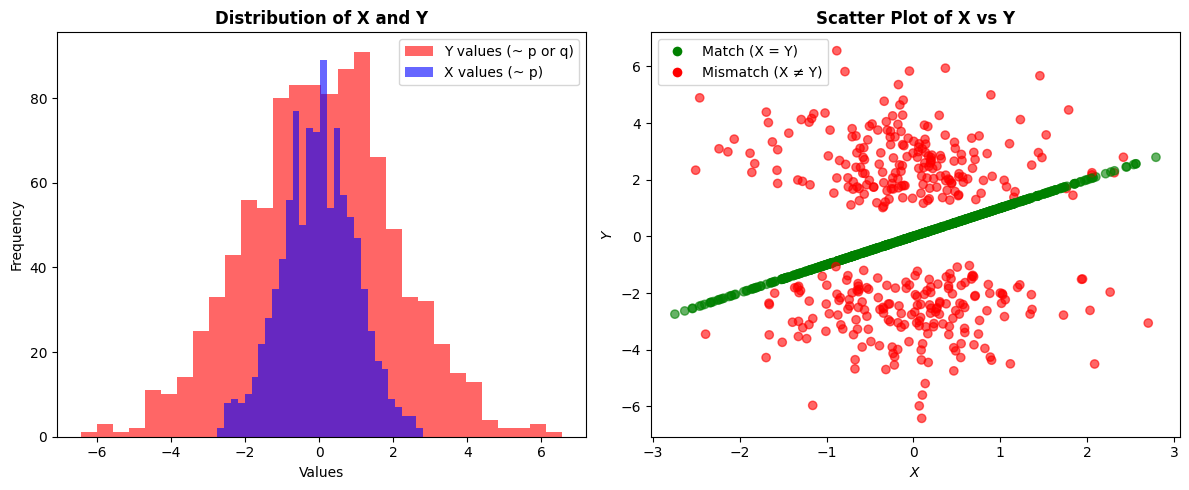

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram Plot of X and Y
ax1.hist(Y_values, bins=30, alpha=0.6, label="Y values (~ p or q)", color='red')
ax1.hist(X_values, bins=30, alpha=0.6, label="X values (~ p)", color='blue')
ax1.set_title("Distribution of X and Y", fontweight='bold')
ax1.set_xlabel("Values")
ax1.set_ylabel("Frequency")
ax1.legend()

# Scatter plot of Matches and Mismatches
colors = ['green' if m else 'red' for m in matches]
ax2.scatter(X_values, Y_values, c=colors, alpha=0.6)
ax2.set_title('Scatter Plot of X vs Y', fontweight='bold')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Match (X = Y)'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Mismatch (X ≠ Y)')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

*Why is Thorisson’s algorithm valid? How does it relates to rejection sampling?*